In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

In [2]:
# Open the dataset file
raw_data = pd.read_csv('dataset_phishing.csv')
pd.set_option('display.max_columns', None)
raw_data.sample(5)

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
8964,http://escueladearte3.es,24,17,0,1,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.041667,0.058824,0,0,0,0,0,1,0,0,0,0,0,0,1,0,14,14,0,14,14,0,14.000000,14.0,0.000000,0,0,0,0,0,0,47,0.042553,0.957447,0,6,0,0.0,0,0.066667,0,1,0.0,0,0.0,100.0,0,0,0,50.0,0,0,0,1,0,1,0,-1,0,0,0,2,legitimate
3058,http://www.gradshower.com/wp-content/plugins/U...,100,18,1,3,1,0,0,0,0,0,0,0,0,8,0,1,0,0,0,0,1,0,0,0,1,0.220000,0.000000,0,0,0,0,0,3,1,0,0,0,0,0,10,5,2,3,2,32,10,32,8.000000,6.5,8.375000,3,0,0,0,0,0,124,0.951613,0.048387,0,1,0,0.0,0,0.000000,0,1,97.5,0,100.0,0.0,0,0,0,88.0,0,0,0,1,1,0,112,254,0,0,1,0,phishing
3739,https://trafftraff.com/l/23821365c9dc52d4bdd0?...,155,14,1,1,0,0,1,3,0,4,5,0,0,4,0,1,0,0,0,0,0,1,0,0,0,0.393548,0.000000,0,0,1,0,0,1,0,0,0,0,0,0,14,9,1,10,1,45,10,45,9.142857,10.0,9.076923,0,0,0,0,0,0,3,1.000000,0.000000,0,0,0,0.0,0,0.000000,0,0,100.0,0,0.0,0.0,0,0,0,0.0,0,0,0,1,0,0,0,-2,4800627,0,1,2,phishing
2617,http://app44666604777.blogspot.com/,35,27,1,2,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,1,0.314286,0.407407,0,0,0,0,0,2,0,0,1,0,1,0,2,11,8,8,0,14,14,0,11.000000,11.0,0.000000,0,1,0,0,0,0,5,0.000000,1.000000,0,1,0,0.0,0,0.000000,0,1,0.0,0,0.0,0.0,0,0,0,0.0,0,0,0,1,1,0,374,7296,0,0,1,5,phishing
6315,https://www.google.com/url?sa=t&rct=j&q=&esrc=...,203,14,0,4,0,0,1,10,0,11,0,0,4,3,0,1,0,0,0,0,2,1,0,1,0,0.059113,0.000000,0,0,1,0,0,3,0,0,0,0,0,0,30,11,1,3,1,40,6,40,5.366667,4.5,5.428571,1,1,0,0,0,0,0,0.000000,0.000000,0,0,0,0.0,0,0.000000,0,0,0.0,0,0.0,0.0,0,0,0,0.0,0,0,1,1,0,0,2975,8347,1,0,0,10,phishing


In [3]:
# Check for missing (NAN) values in the columns
raw_data.isna().sum()

url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
status             0
Length: 89, dtype: int64

In [4]:
# Remove columns that have the same value for all rows in the dataset
def remove_constant_columns(df):
    # Identify constant columns
    constant_columns = [col for col in df.columns if df[col].nunique() == 1]
    print("Columns with constant values:", constant_columns)
    
    # Drop constant columns
    df_cleaned = df.drop(columns=constant_columns)
    
    # Print the number of columns in the cleaned DataFrame
    print("Number of remaining columns:", df_cleaned.shape[1])
    return df_cleaned
    
df_cleaned = remove_constant_columns(raw_data)

Columns with constant values: ['nb_or', 'ratio_nullHyperlinks', 'ratio_intRedirection', 'ratio_intErrors', 'submit_email', 'sfh']
Number of remaining columns: 83


<Axes: xlabel='status'>

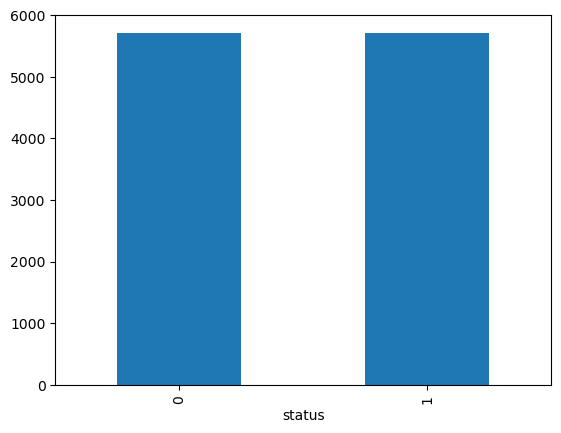

In [5]:
# Examine the features of the cleaned dataset.
features = df_cleaned.columns.tolist()
# Change the "status" column format from string to numeric(1/0) which will be used as a label to determine if the URL is phishing or not
df_cleaned['status'] = df_cleaned['status'].map({'phishing': 1, 'legitimate': 0})
# Check if the dataset is balanced - phishing urls count ?= legitimate urls count
df_cleaned['status'].value_counts().plot(kind='bar')

In [6]:
# Summarizes statistics of numeric columns (count, mean, std, min, 25th, 50th, 75th percentiles, max)
df_cleaned.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,nb_extCSS,ratio_extRedirection,ratio_extErrors,login_form,external_favicon,links_in_tags,ratio_intMedia,ratio_extMedia,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.00000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000,11430.000000
mean,61.126684,21.090289,0.150569,2.480752,0.997550,0.022222,0.141207,0.162292,0.293176,0.322660,0.006649,0.123097,4.289589,0.000700,1.027909,0.004024,0.062292,0.001925,0.034821,0.448469,0.127997,0.006562,0.016710,0.610936,0.053137,0.025024,0.000350,0.002362,0.065617,0.050131,0.021610,2.231671,0.202450,0.083290,0.123447,0.000175,0.498250,0.003150,6.232808,2.927472,3.127297,5.019773,2.398950,15.393876,10.467979,10.561505,7.258882,7.678075,5.092425,0.327734,0.104199,0.004112,0.004899,0.017935,0.059755,87.189764,0.602457,0.276720,0.784864,0.158926,0.062469,0.063605,0.442170,51.978211,42.870444,23.236293,0.001312,0.006037,37.063922,0.001137,0.00140,0.124759,0.775853,0.439545,0.072878,492.532196,4062.543745,8.567566e+05,0.020122,0.533946,3.185739,0.500000
std,55.297318,10.777171,0.357644,1.369686,2.087087,0.155500,0.364456,0.821337,0.998317,1.093336,0.081274,1.466450,1.882251,0.026448,0.240325,0.103240,0.598190,0.077111,0.375576,0.501912,0.379008,0.080742,0.169358,0.487559,0.089363,0.093422,0.018705,0.048547,0.247622,0.218225,0.145412,0.637069,0.401843,0.276332,0.328964,0.013227,0.691907,0.056035,5.572355,4.768936,2.211571,3.941580,2.997809,22.083644,4.932015,23.077883,4.145827,3.578435,7.147050,0.842600,0.305533,0.063996,0.069827,0.132722,0.331266,166.758254,0.376474,0.319958,2.758802,0.266437,0.156209,0.244058,0.496666,41.523144,46.249897,38.386577,0.036204,0.077465,39.073385,0.033707,0.03739,0.330460,0.417038,0.496353,0.259948,814.769415,3107.784600,1.995606e+06,0.140425,0.498868,2.536955,0.500022
min,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000

In [7]:
# Visualise the columns of the cleaned data
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 83 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_eq                       11430 non-null  int64  
 10  nb_underscore               11430 non-null  int64  
 11  nb_tilde                    11430 non-null  int64  
 12  nb_percent                  11430 non-null  int64  
 13  nb_slash                    114

In [8]:
# Select only the numerical columns from the dataframe (exclude the string type "url" column which is not a feature)
numerical_data = df_cleaned.select_dtypes(include=['float64', 'int64'])
# Compute the correlation matrix on the numerical columns
corr_matrix = numerical_data.corr()
# Track the corelations to the "status" column
status_corr = corr_matrix['status']
status_corr

length_url         0.248580
length_hostname    0.238322
ip                 0.321698
nb_dots            0.207029
nb_hyphens        -0.100107
                     ...   
web_traffic        0.060388
dns_record         0.122119
google_index       0.731171
page_rank         -0.511137
status             1.000000
Name: status, Length: 82, dtype: float64

In [9]:
# Function for selecting features that are above than threshold correlation with the "status" value 
def feature_selector_correlation(cmatrix, threshold):
    selected_features = []
    feature_score = []
    i=0
    for score in cmatrix:
        if abs(score)>threshold:
            selected_features.append(cmatrix.index[i])
            feature_score.append( ['{:3f}'.format(score)])
        i+=1
    result = list(zip(selected_features,feature_score))
    return result
    
selected_features = feature_selector_correlation(status_corr, 0.23)
selected_features = [feature for feature in selected_features if feature[0] != 'status']

print("Significant features that have a strong linear correlation with the status of the url (phishing or not) -",  len(selected_features), ":")
selected_features

Significant features that have a strong linear correlation with the status of the url (phishing or not) - 15 :


[('length_url', ['0.248580']),
 ('length_hostname', ['0.238322']),
 ('ip', ['0.321698']),
 ('nb_qm', ['0.294319']),
 ('nb_eq', ['0.233386']),
 ('nb_slash', ['0.242270']),
 ('nb_www', ['-0.443468']),
 ('ratio_digits_url', ['0.356395']),
 ('phish_hints', ['0.335393']),
 ('nb_hyperlinks', ['-0.342628']),
 ('ratio_intHyperlinks', ['-0.243982']),
 ('domain_in_title', ['0.342807']),
 ('domain_age', ['-0.331889']),
 ('google_index', ['0.731171']),
 ('page_rank', ['-0.511137'])]

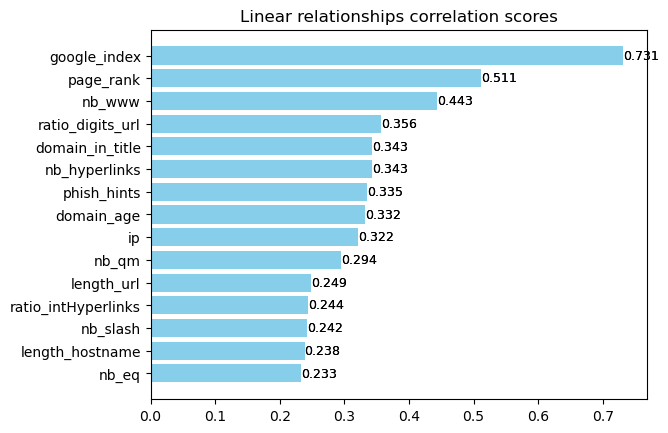

<Figure size 700x700 with 0 Axes>

In [10]:
# Visual representation of the feature selection based on linear correlation with the status
def plot_scores(scores, highlight_features=None):
    scores = scores.sort_values(ascending=True).head(15)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    for i, score in enumerate(scores):
        plt.text(score, i, f'{score:.3f}', va='center', ha='left', fontsize=9, color='black')
    # Loop over the scores to plot them
    for i, (score, feature) in enumerate(zip(scores, ticks)):
        # Color bars differently for features in the highlight list
        color = 'purple' if highlight_features and feature in highlight_features else 'skyblue'
        
        # Plot the bar with the appropriate color
        plt.barh(i, score, color=color)
        
        # Annotate the bars with the values
        plt.text(score, i, f'{score:.3f}', va='center', ha='left', fontsize=9, color='black')
    plt.yticks(width, ticks)
    plt.figure(dpi=100, figsize=(7,7))
    
scores = pd.Series({item[0]: float(item[1][0]) for item in selected_features})
absolute_linear_scores = scores.abs()
plt.title("Linear relationships correlation scores")
plot_scores(absolute_linear_scores)

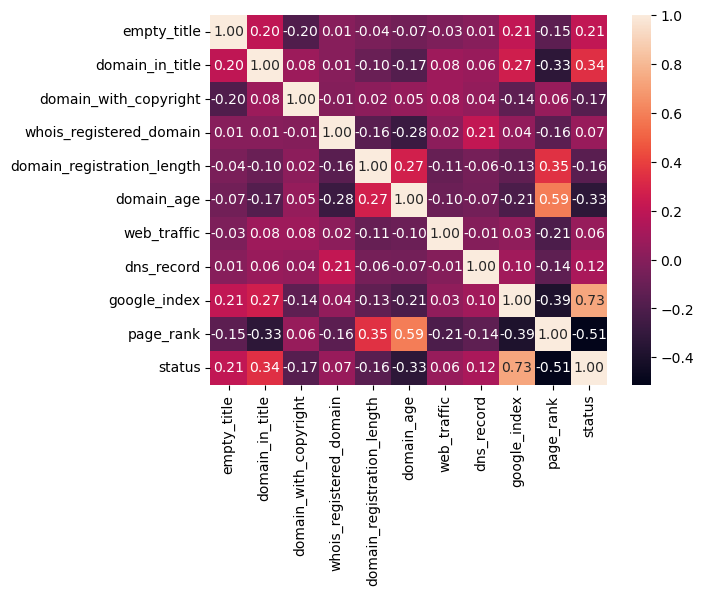

In [11]:
# Double check the selected columns correlation to the "status" column using the spearman's correlation matric heatmap
def corr_heatmap(data, idx_s, idx_e):
    y = data['status']
    temp = data.iloc[:, idx_s:idx_e]
    if 'url' in temp.columns:
        del temp['url']
    temp['status'] = y
    sns.heatmap(temp.corr(), annot=True, fmt='.2f')
    plt.show()
    
corr_heatmap(df_cleaned, 72, 82)

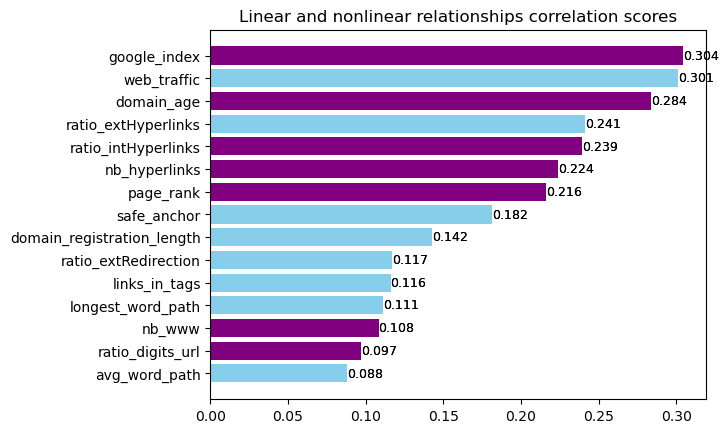

<Figure size 700x700 with 0 Axes>

In [12]:
# Using only linear relationships correlation might not be very accurate way to select the most important features.
# Using the function sklearn's mutual_info_classif function is especially designed to solve this selection task based on both linear and nonlinear relationships in the data.
from sklearn.feature_selection import mutual_info_classif

X = df_cleaned.drop(['url', 'status'], axis=1)
Y = df_cleaned['status']

discrete_features = X.dtypes == int
mi_scores = mutual_info_classif(X, Y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

absolute_linear_scores_names = absolute_linear_scores.index.tolist()

plt.title("Linear and nonlinear relationships correlation scores")
plot_scores(mi_scores.head(15), highlight_features=absolute_linear_scores_names)

In [13]:
# Update the features for model training to contain only the top 15 mutual info top scored features.
top_mi_scored_features_names = mi_scores.head(15).index.tolist()
X = df_cleaned[top_mi_scored_features_names] 

In [14]:
# Import the models Naive Bayes, KNN, LogisticRegression, RandomForestClassifier, MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [15]:
# transform the dataset in appropriate format for model training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=41)

# Without scaling, features with larger ranges (e.g., length_url) might dominate the model,
# while features with smaller ranges (e.g., google_index) might be ignored.
# By scaling, all features receive equal opportunity to influence the model.
scaler = StandardScaler()
# The test data is scaled using the mean and standard deviation derived from the training set only
X_train_scaled = scaler.fit_transform(X_train)
# The test set remains unseen during training
X_test_scaled = scaler.transform(X_test)

# Initiate the models
classifiers = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(verbose=True),
    'Random Forest': RandomForestClassifier(verbose=True),
    'MLP Classifier': MLPClassifier(verbose=True)
}
# Set different hyperparameter configurations for each model so that the best is picked up by GridSearchCV
param_grids = {
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'p': [1, 2, 3]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20]
    },
    'MLP Classifier': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'max_iter': [500, 1000],
        'learning_rate_init': [0.001, 0.0005],
        'early_stopping': [True]
    }
}

In [16]:
# Train all models with the different hyperparameters
trained_models = {}

start_time = datetime.now()
print(f"Training started at: {start_time.strftime('%H:%M:%S')}")

for name, clf in classifiers.items():
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[name], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_scaled, Y_train)
    trained_models[name] = grid_search

end_time = datetime.now()
print(f"Training finished at: {end_time.strftime('%H:%M:%S')}")

Training started at: 23:39:52


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.3s


Iteration 1, loss = 0.62024064
Validation score: 0.786713
Iteration 2, loss = 0.44029252
Validation score: 0.882284
Iteration 3, loss = 0.30970871
Validation score: 0.890443
Iteration 4, loss = 0.24371481
Validation score: 0.898601
Iteration 5, loss = 0.21916852
Validation score: 0.898601
Iteration 6, loss = 0.20842562
Validation score: 0.898601
Iteration 7, loss = 0.20130302
Validation score: 0.905594
Iteration 8, loss = 0.19654335
Validation score: 0.902098
Iteration 9, loss = 0.19233440
Validation score: 0.903263
Iteration 10, loss = 0.18871809
Validation score: 0.903263
Iteration 11, loss = 0.18563964
Validation score: 0.903263
Iteration 12, loss = 0.18246242
Validation score: 0.905594
Iteration 13, loss = 0.18027894
Validation score: 0.903263
Iteration 14, loss = 0.17786788
Validation score: 0.903263
Iteration 15, loss = 0.17575377
Validation score: 0.906760
Iteration 16, loss = 0.17382723
Validation score: 0.906760
Iteration 17, loss = 0.17195988
Validation score: 0.906760
Iterat

In [17]:
# Print the training results for each model
for name, grid_search in trained_models.items():
    print(f"{name}:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    best_model = grid_search.best_estimator_
    Y_pred = best_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(Y_test, Y_pred)
    print("Test Accuracy:", test_accuracy)
    print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
    print("Classification Report:\n", classification_report(Y_test, Y_pred))
    print()

Naive Bayes:
Best Parameters: {'var_smoothing': 1e-09}
Best Score: 0.8985078465458528
Test Accuracy: 0.903778866340098
Confusion Matrix:
 [[1293   86]
 [ 189 1290]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      1379
           1       0.94      0.87      0.90      1479

    accuracy                           0.90      2858
   macro avg       0.90      0.90      0.90      2858
weighted avg       0.91      0.90      0.90      2858


KNN:
Best Parameters: {'n_neighbors': 9, 'p': 1}
Best Score: 0.9387540100220786
Test Accuracy: 0.9415675297410777
Confusion Matrix:
 [[1292   87]
 [  80 1399]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1379
           1       0.94      0.95      0.94      1479

    accuracy                           0.94      2858
   macro avg       0.94      0.94      0.94      2858
weighted avg       0.94    

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [18]:
# Print the best version of each model type + the hyperparameters that achieve it
print("Summary of Best Models:")
for name, grid_search in trained_models.items():
    print(f"{name}:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score (CV):", grid_search.best_score_)
    print()

Summary of Best Models:
Naive Bayes:
Best Parameters: {'var_smoothing': 1e-09}
Best Score (CV): 0.8985078465458528

KNN:
Best Parameters: {'n_neighbors': 9, 'p': 1}
Best Score (CV): 0.9387540100220786

Logistic Regression:
Best Parameters: {'C': 1}
Best Score (CV): 0.9190374586240564

Random Forest:
Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Best Score (CV): 0.9526360515868291

MLP Classifier:
Best Parameters: {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.0005, 'max_iter': 1000, 'solver': 'adam'}
Best Score (CV): 0.9326877608853176



Recap for the Naive Bayes model:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      1379
           1       0.94      0.87      0.90      1479

    accuracy                           0.90      2858
   macro avg       0.90      0.90      0.90      2858
weighted avg       0.91      0.90      0.90      2858

Precision: 0.91
Recall: 0.90
F1 Score: 0.90
Accuracy: 0.90


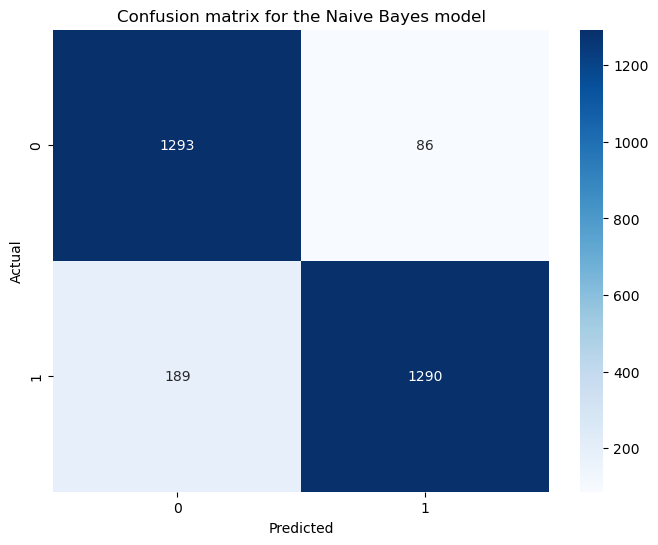


Recap for the KNN model:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1379
           1       0.94      0.95      0.94      1479

    accuracy                           0.94      2858
   macro avg       0.94      0.94      0.94      2858
weighted avg       0.94      0.94      0.94      2858

Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Accuracy: 0.94


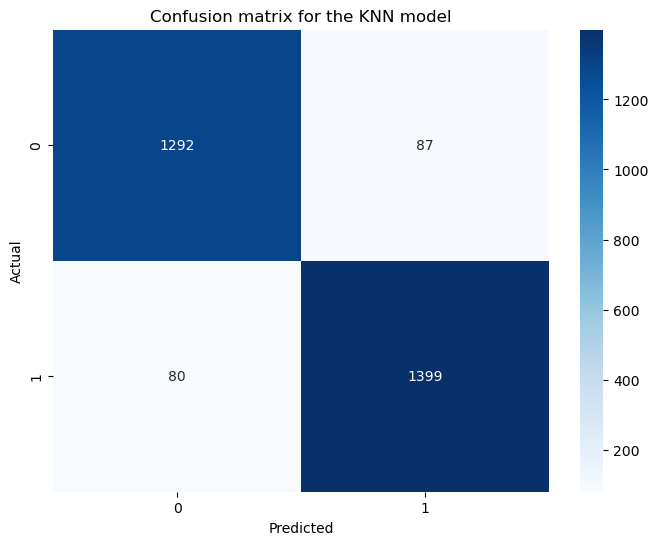


Recap for the Logistic Regression model:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      1379
           1       0.93      0.92      0.92      1479

    accuracy                           0.92      2858
   macro avg       0.92      0.92      0.92      2858
weighted avg       0.92      0.92      0.92      2858

Precision: 0.92
Recall: 0.92
F1 Score: 0.92
Accuracy: 0.92


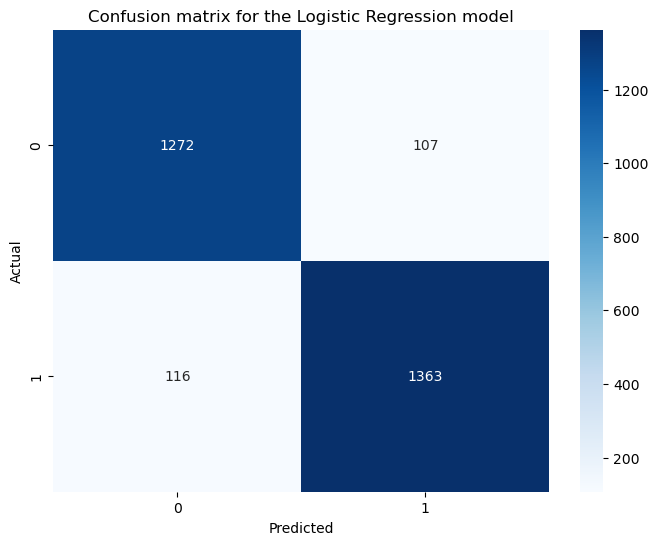


Recap for the Random Forest model:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      1379
           1       0.97      0.96      0.96      1479

    accuracy                           0.96      2858
   macro avg       0.96      0.96      0.96      2858
weighted avg       0.96      0.96      0.96      2858

Precision: 0.96
Recall: 0.96
F1 Score: 0.96
Accuracy: 0.96


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


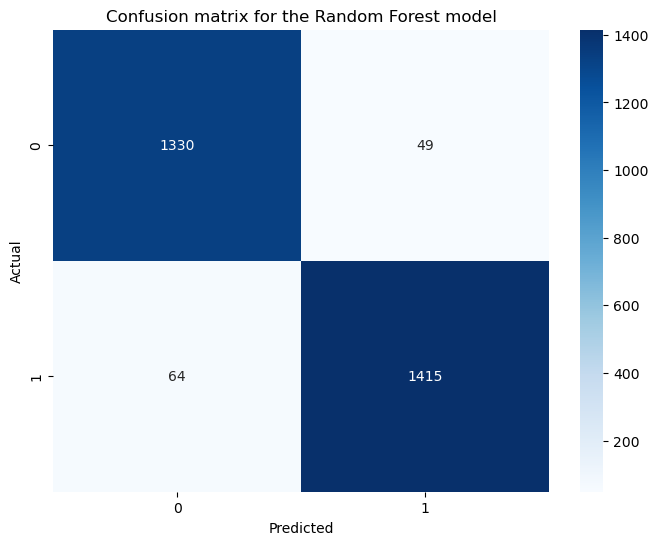


Recap for the MLP Classifier model:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1379
           1       0.95      0.93      0.94      1479

    accuracy                           0.94      2858
   macro avg       0.94      0.94      0.94      2858
weighted avg       0.94      0.94      0.94      2858

Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Accuracy: 0.94


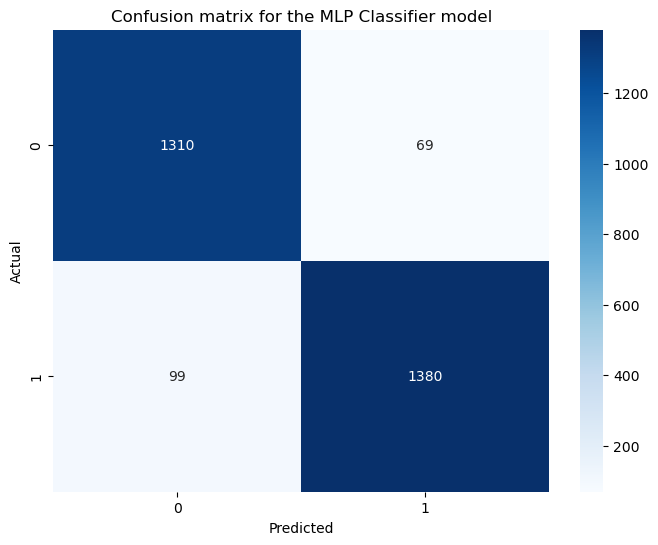

In [19]:
# Visualise the confusion matrix + precision, recall, f1 score and accuracy stats for each model type
for name, grid_search in trained_models.items():
    Y_pred = grid_search.predict(X_test_scaled)
    print("Recap for the " + name +" model:\n", classification_report(Y_test, Y_pred) )
    
    conf_matrix = confusion_matrix(Y_test, Y_pred);
    report = classification_report(Y_test, Y_pred, output_dict=True);
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")
    print(f"Accuracy: {accuracy:.2f}")


    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion matrix for the ' + name + " model")
    plt.show()
    print()

In [20]:
# Test the models on example urls we would see in the real life to examine their performance outside of the dataset field
# Rough example feature extraction function is used (NOT accurate, made up just for testing and development purposes)
def extract_features(url):
    from urllib.parse import urlparse
    import re
    
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    path = parsed_url.path

    features = {}
    features['google_index'] = 10 if "google.com" in domain else 0  # Only flag 'google.com' domain
    features['web_traffic'] = len(url) * 5  # Adjust the scaling multiplier
    features['domain_age'] = 10 if ".com" in domain else 3  # Domain age; assume .com domains are older
    features['ratio_extHyperlinks'] = path.count('/') / len(url) if len(url) > 0 else 0
    features['ratio_intHyperlinks'] = domain.count('.') / len(url) if len(url) > 0 else 0
    features['nb_hyperlinks'] = url.count('/') + url.count('.')
    features['page_rank'] = 0.9 if domain.endswith((".com", ".org")) else 0.2  # PageRank for common TLDs
    features['safe_anchor'] = 1 if re.search(r'(?i)\b(safe|secure|verification)\b', path) else 0
    features['domain_registration_length'] = 3650 if domain.endswith(".com") else 365  # Longer for .com domains
    features['links_in_tags'] = len(path.split('/')) - 1  # Path depth based on '/'
    features['ratio_extRedirection'] = 1 if "redirect" in url else 0  # Flag for redirection in URL
    features['longest_word_path'] = max([len(word) for word in path.split('/') if word], default=0)  # Longest word in path
    features['nb_www'] = domain.count('www')  # Number of 'www' subdomains
    features['ratio_digits_url'] = sum(c.isdigit() for c in url) / len(url) if len(url) > 0 else 0  # Digit ratio
    features['ratio_extErrors'] = 0.5 if "error" in url else 0  # Error term based on 'error' in URL
    return list(features.values())

# Transform URLs into feature vectors first
real_features = [extract_features(url) for url in ["https://www.youtube.com/", "https://www.microsoft.com/en-us", 
                                                   "https://www.amazon.com", "https://www.wikipedia.org", 
                                                   "https://www.paypal.com"]]
phishing_features = [extract_features(url) for url in [ "http://secure-go0gle-login.verification.com",  # Mimics Google login
                                                        "https://microsoft-update.support-login.info",  # Mimics Microsoft support
                                                         "http://amz-login-services.xyz",               # Mimics Amazon services
                                                         "https://paypal-secure-check.xyz",             # Mimics PayPal secure login
                                                         "http://account-verification-paypall.net"]]    # Mimics PayPal account verification

# Scale the feature vectors
real_features_scaled = scaler.transform(real_features)
phishing_features_scaled = scaler.transform(phishing_features)

# Use the trained models for predictions
for name, grid_search in trained_models.items():
    real_addresses_pred = grid_search.predict(real_features_scaled)
    phishing_addresses_pred = grid_search.predict(phishing_features_scaled)
    
    print(f"Predictions for {name} model:")
    print("Real addresses:", real_addresses_pred)
    print("Phishing addresses:", phishing_addresses_pred)
    print()

Predictions for Naive Bayes model:
Real addresses: [0 0 0 0 0]
Phishing addresses: [0 1 1 1 1]

Predictions for KNN model:
Real addresses: [0 0 0 0 0]
Phishing addresses: [1 1 1 1 1]

Predictions for Logistic Regression model:
Real addresses: [0 0 0 0 0]
Phishing addresses: [1 1 1 1 1]

Predictions for Random Forest model:
Real addresses: [0 0 0 0 0]
Phishing addresses: [1 1 1 1 1]

Predictions for MLP Classifier model:
Real addresses: [0 0 0 0 0]
Phishing addresses: [1 1 1 1 1]



E:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
E:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


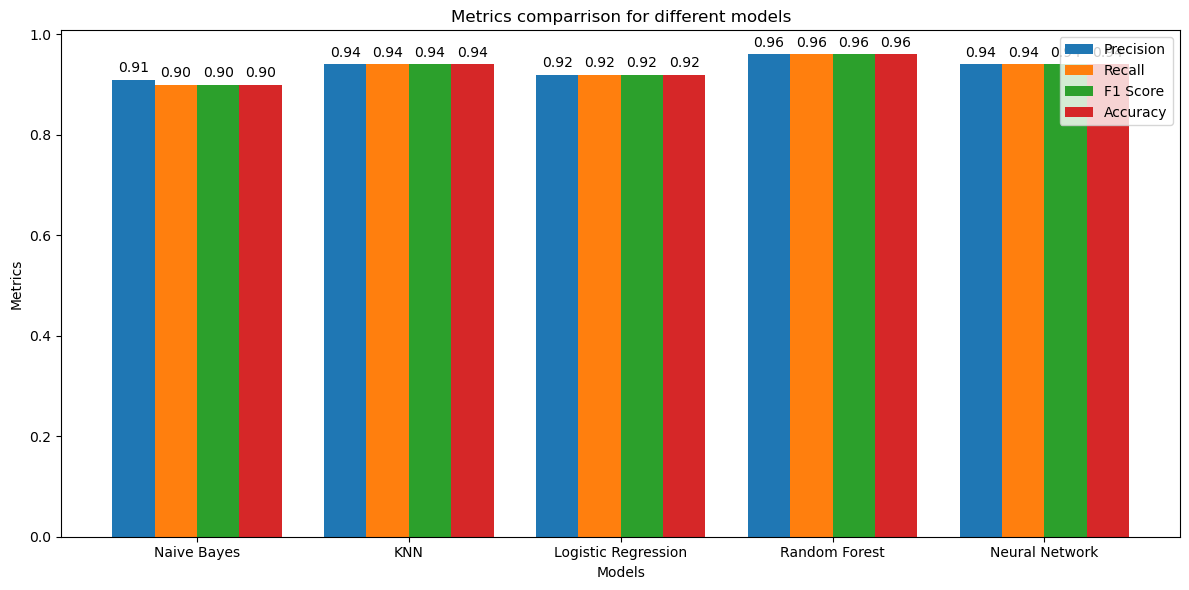

In [21]:
models = ['Naive Bayes', 'KNN', 'Logistic Regression', 'Random Forest', 'Neural Network']
precision = [0.91, 0.94, 0.92, 0.96, 0.94]
recall = [0.90, 0.94, 0.92, 0.96, 0.94]
f1_score = [0.90, 0.94, 0.92, 0.96, 0.94]
accuracy = [0.90, 0.94, 0.92, 0.96, 0.94]

x = np.arange(len(models))  
width = 0.2  

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width*1.5, precision, width, label='Precision')
rects2 = ax.bar(x - width/2, recall, width, label='Recall')
rects3 = ax.bar(x + width/2, f1_score, width, label='F1 Score')
rects4 = ax.bar(x + width*1.5, accuracy, width, label='Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Metrics')
ax.set_title('Metrics comparrison for different models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()